# Spectral Normalization for Generative Adversarial Networks (SN-GAN)

#### One of the challenges in the study of generative adversarial networks is the instability of its training. In this article, I propose a novel weight normalization technique called spectral normalization to stabilize the training of the discriminator

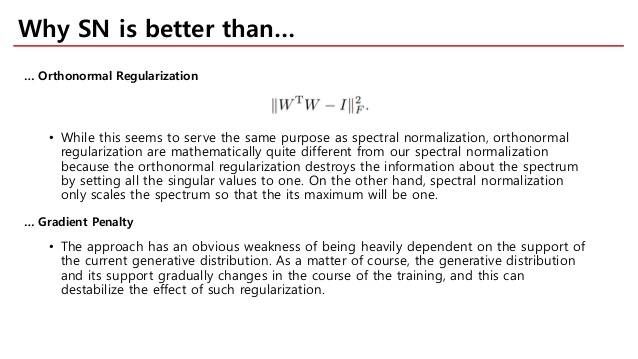

#### SN-GAN normalizes the weight matrices in the discriminator by their corresponding spectral norm, which helps to control the Lipschitz(ensures boundedness of the optimal discriminator) constant of the discriminator.

###Research Paper : https://arxiv.org/abs/1802.05957#:~:text=One%20of%20the%20challenges%20in,the%20training%20of%20the%20discriminator.
<br>

## DCGAN with Spectral Normalization

In [1]:
#importing required libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Generator
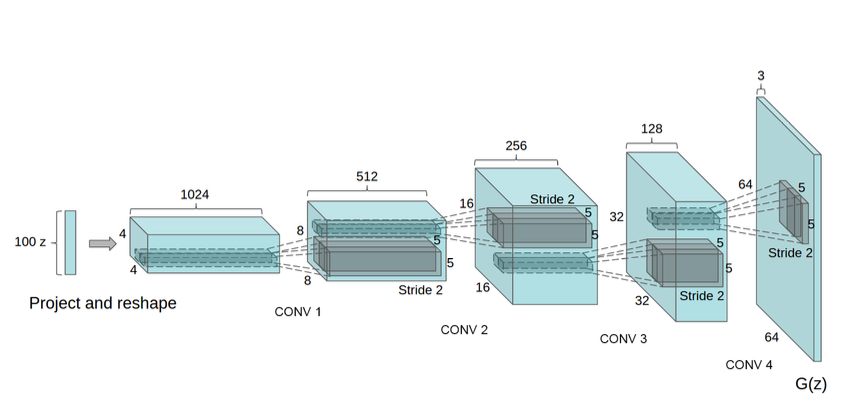

In [2]:
# Generator (for generating fake images)

class Generator(nn.Module):
  
    # z_dim : noise vector dimension
    # output_channel : tnumber of channels of the output image, it is 1 for MNIST(black and white) dataset.
    # hidden_dimension : inner dimension of the generator model

    def __init__(self, z_dimension=10, output_channel=1, hidden_dimension=64):
        super(Generator, self).__init__()

        self.z_dimension = z_dimension

        # Building the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dimension, hidden_dimension * 2),
            self.make_gen_block(hidden_dimension * 2, hidden_dimension * 4),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 8, stride=1),
            self.make_gen_block(hidden_dimension * 8, hidden_dimension * 4, stride=1),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 2, stride=1),
            self.make_gen_block(hidden_dimension * 2, output_channel, kernel_size=4, final_layer=True),
        )


    # building neural block
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channel
        # output_channels : number of output channel
        # kernel_size : size of convolutional filter
        # stride : stride of the convolution
        # final_layer : boolean value, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )

        # Final Layer
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
  
    # Function for completing a forward pass of the generator: Given a noise tensor, returns generated images.
    def forward(self, noise):
        
        # noise: a noise tensor with dimensions (n_samples, z_dimension)
        

        # a noise with width = 1, height = 1, number of channels = z_dimension, number of samples = len(noise)
        x = noise.view(len(noise), self.z_dimension, 1, 1)
        return self.gen(x)


    # Function for creating noise vectors: Given the dimensions (n_samples, z_dim) creates a tensor of that shape filled with random numbers 
    # from the normal distribution
    def get_noise(self, n_samples, device='cpu'):
    
        # n_samples: the number of samples to generate, a scalar
        # z_dimension: the dimension of the noise vector, a scalar
        # device: the device type (cpu / cuda)
    
        return torch.randn(n_samples, self.z_dimension, device=device)

## Discriminator
### Building a discriminator having 4 layers
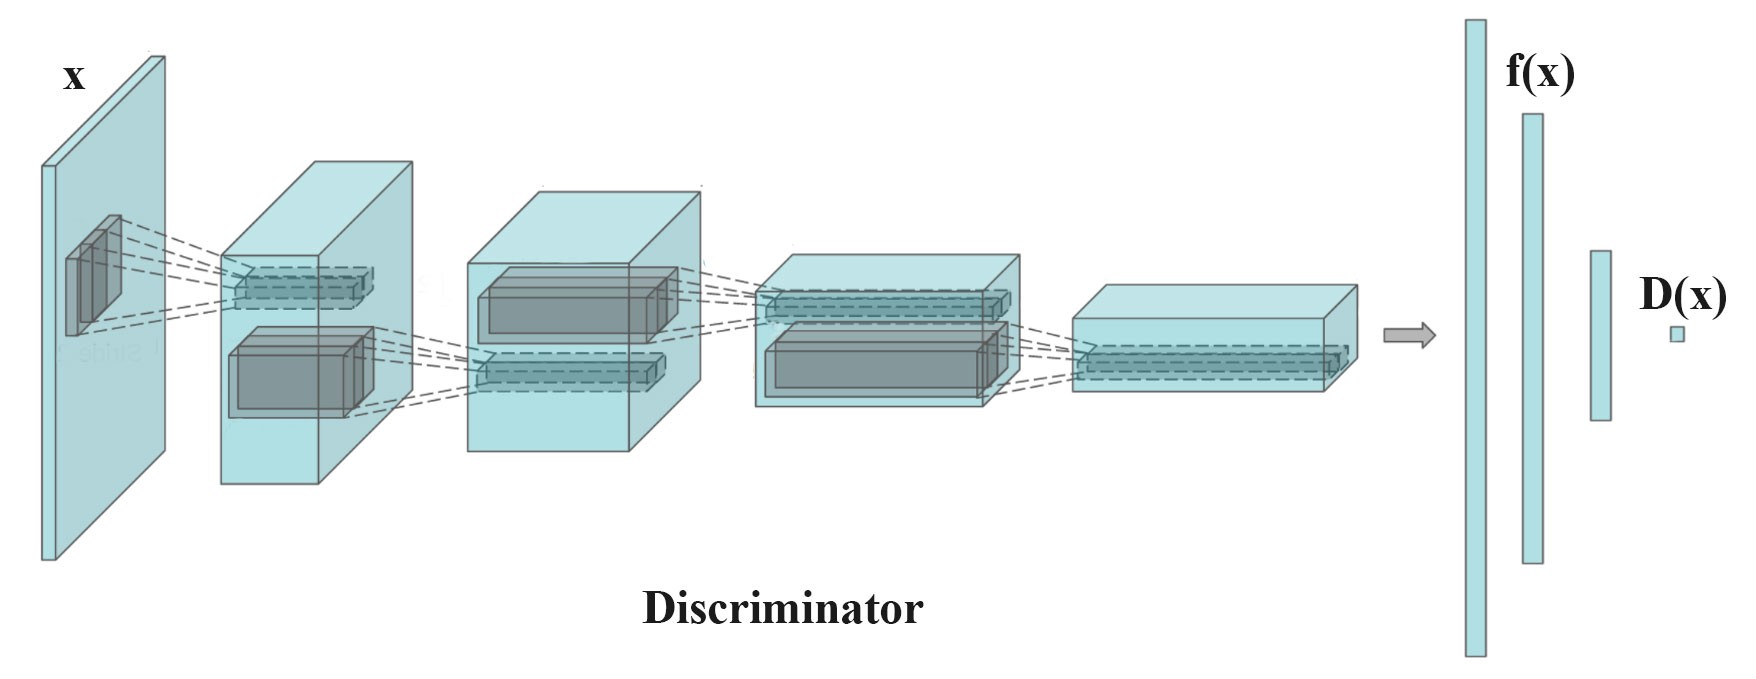

#### It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer.

In [3]:
# Discriminator

class Discriminator(nn.Module):

    # im_chan :  number of output channel (1 channel for MNIST dataset which has balck and white image)
    # hidden_dim : number of inner channel

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim * 2, stride=1),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 2),

            self.make_disc_block(hidden_dim * 2, 1, kernel_size=4, final_layer=True),
        )


    # Build the neural block
    def make_disc_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channels
        # output_channels : number of output channels
        # kernel_size : the size of each convolutional filter
        # stride : the stride of the convolution
        # final_layer : a boolean, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride))
            )

    # Function for completing a forward pass of the discriminator: Given an image tensor, returns a 1-dimension tensor representing fake/real.
    def forward(self, image):
        # image: a flattened image tensor 
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training Parameters

In [4]:
# loss function
criterion = nn.BCEWithLogitsLoss()

# dimension of the noise vector
z_dim = 64

# ow often to display/visualize the images
display_step = 1000

# number of images per forward/backward pass
batch_size = 128

# the learning rate
lr = 0.0002

#the device type 
device = 'cuda'

# the momentum term
beta_1 = 0.5 
beta_2 = 0.999

# the number of times you iterate through the entire dataset when training
n_epochs = 100

## Downloading dataset

In [5]:
# # You can tranform the image values to be between -1 and 1 (the range of the tanh activation)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### initializing generator, discriminator, and optimizers.

In [6]:
#generator
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

#discriminator
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

#### initializing the generator and discriminator weights to the normal distribution with mean 0 and standard deviation 0.02

In [7]:
def weights_init(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Output visualisation

In [8]:
# Function for visualizing images: Given a tensor of images, number of images, and
# size per image, plots and prints the images in an uniform grid.

def show_tensor_images(image_tensor, num_images=16, size=(1, 28, 28)):
    
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


For each epoch, it will process the entire dataset in batches and for every batch, it will update the discriminator and generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 0.714521732985972, discriminator loss: 0.6803333288431167


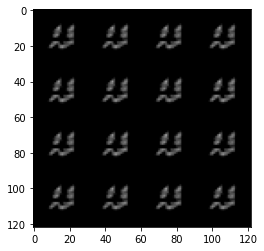

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


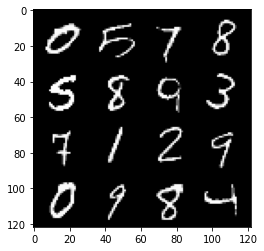

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 1.1488345636725412, discriminator loss: 0.47716268193721717


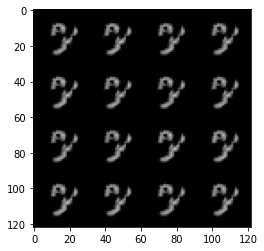

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


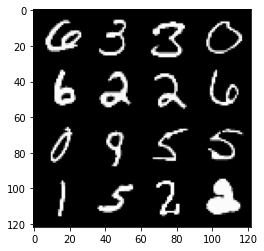

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 1.4397816185355201, discriminator loss: 0.3708472283184525


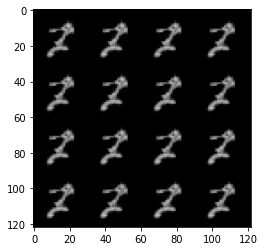

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


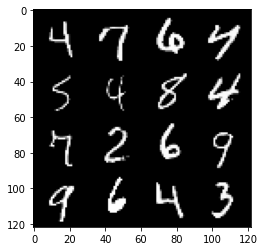

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 1.8491452837586384, discriminator loss: 0.26471222972869873


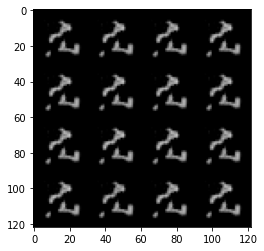

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


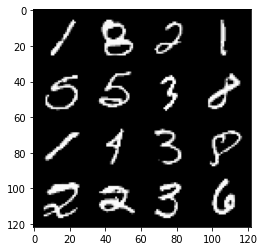

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 1.7869690801501283, discriminator loss: 0.2916698043569925


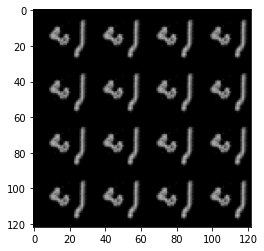

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


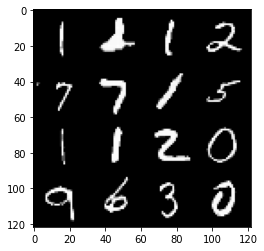

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 2.2977523737549763, discriminator loss: 0.16746192064881296


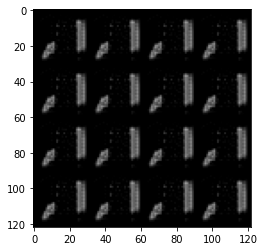

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


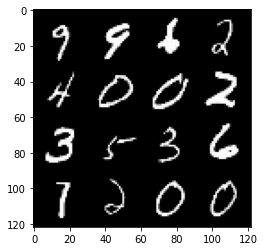

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: 1.9187581121623536, discriminator loss: 0.290603611662984


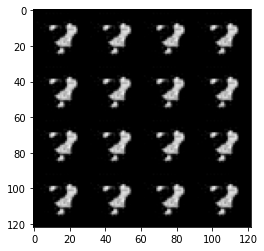

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


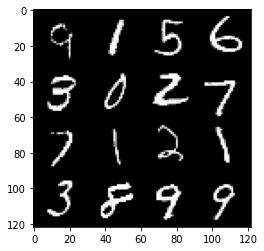

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: 2.268416631639005, discriminator loss: 0.20641438125446446


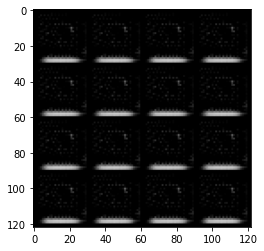

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


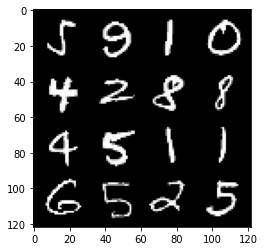

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: 3.3821672847270943, discriminator loss: 0.04478065383434295


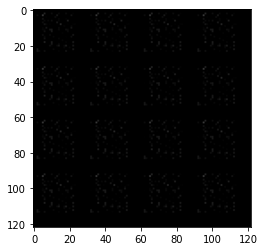

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


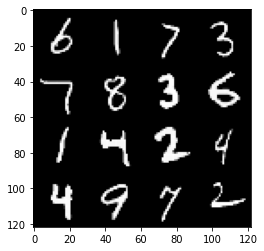

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000: Generator loss: 3.1308061224222206, discriminator loss: 0.10881518877111382


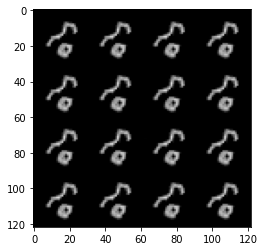

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


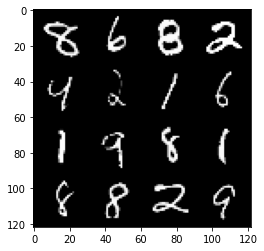

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000: Generator loss: 2.586037693589927, discriminator loss: 0.1701914571076629


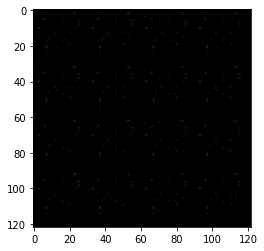

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


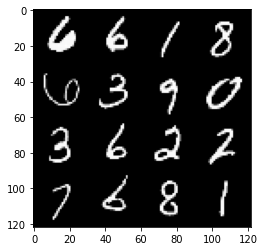

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12000: Generator loss: 3.5547542059421535, discriminator loss: 0.03836872361227871


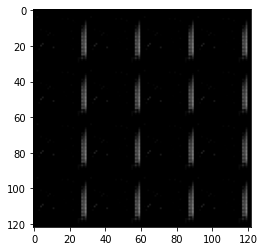

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


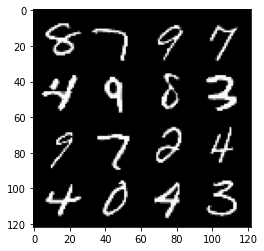

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13000: Generator loss: 4.256360077857971, discriminator loss: 0.018284935705363783


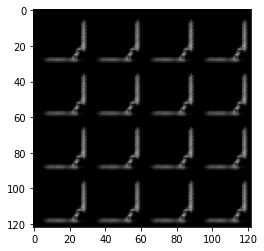

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


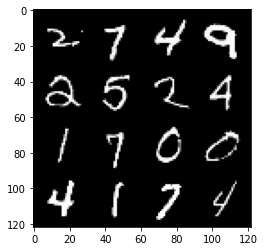

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14000: Generator loss: 4.644295393705372, discriminator loss: 0.012064493902493251


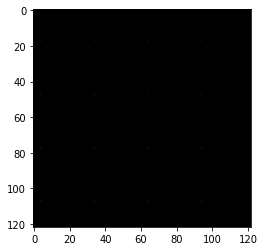

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


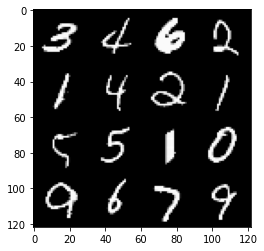

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15000: Generator loss: 5.113664845943446, discriminator loss: 0.007165115325246005


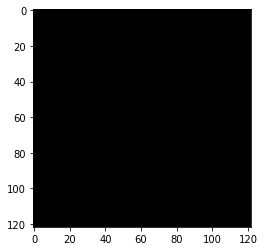

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


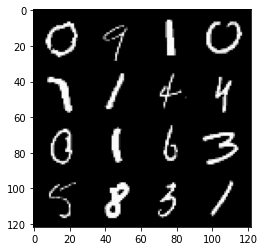

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16000: Generator loss: 3.237339165568353, discriminator loss: 0.1566730564709288


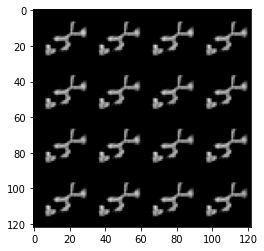

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


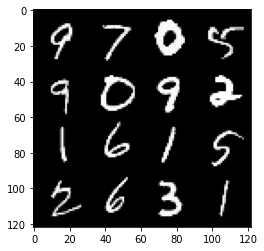

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17000: Generator loss: 2.669075797200203, discriminator loss: 0.15046095512807373


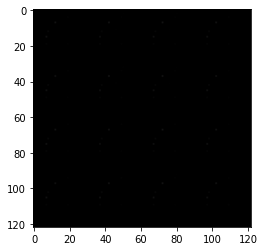

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


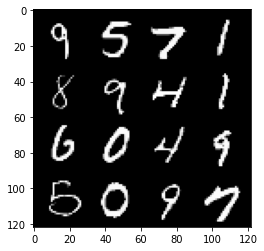

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18000: Generator loss: 4.071180092811585, discriminator loss: 0.024900277099572144


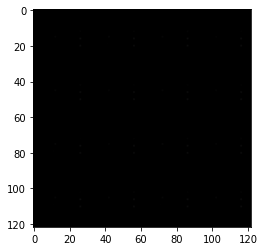

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


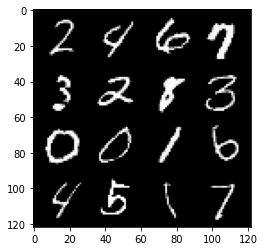

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19000: Generator loss: 4.955960324287414, discriminator loss: 0.008950101868249466


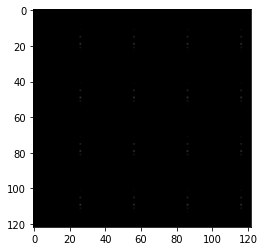

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


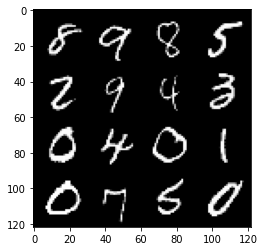

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20000: Generator loss: 5.367306824684135, discriminator loss: 0.005682194367982455


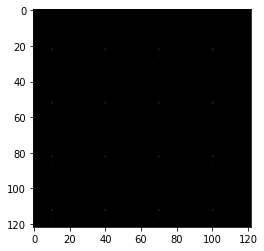

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


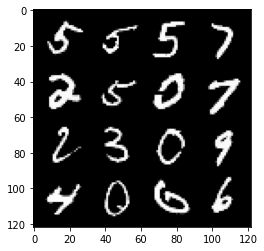

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 21000: Generator loss: 3.510955130472772, discriminator loss: 0.13722879235527974


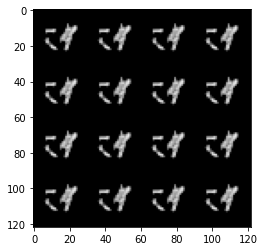

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


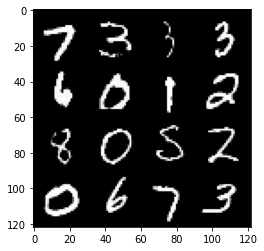

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 22000: Generator loss: 2.5722447158098247, discriminator loss: 0.18355292939394688


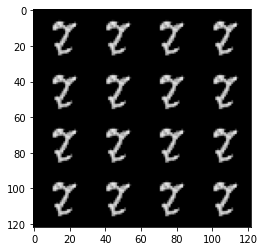

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


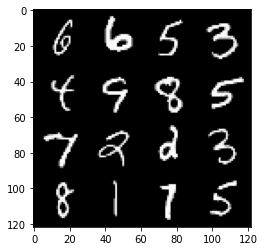

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 23000: Generator loss: 3.31334189116955, discriminator loss: 0.08565141605585816


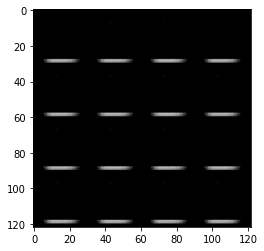

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


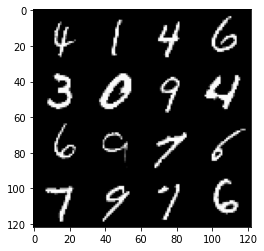

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 24000: Generator loss: 4.536452138900759, discriminator loss: 0.015201814977452143


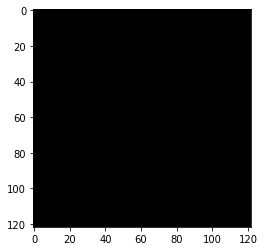

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


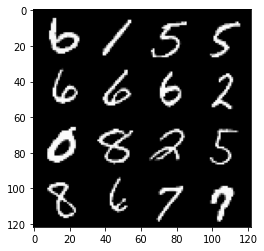

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 25000: Generator loss: 5.267582715034481, discriminator loss: 0.0072103597561363145


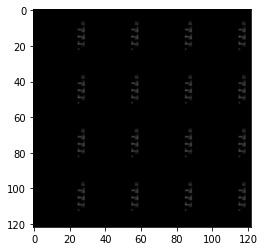

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


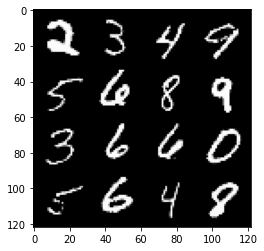

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 26000: Generator loss: 5.340169751942161, discriminator loss: 0.01896944309899118


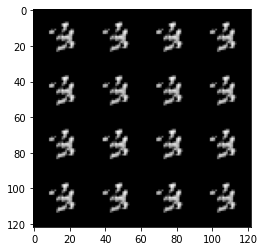

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


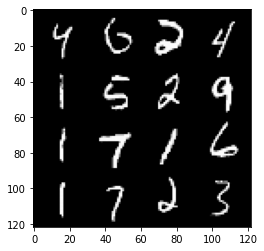

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 27000: Generator loss: 2.9734288275241836, discriminator loss: 0.13643129489198305


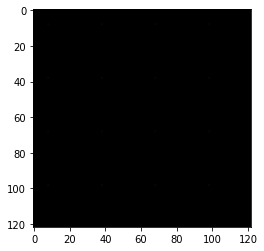

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


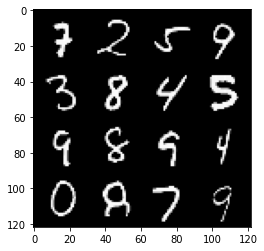

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 28000: Generator loss: 4.459494624137872, discriminator loss: 0.019790555821964508


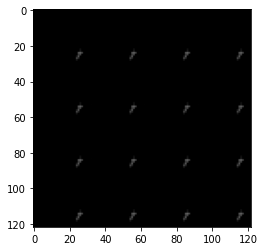

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


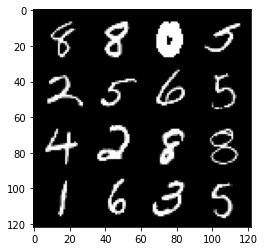

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 29000: Generator loss: 5.220091743946073, discriminator loss: 0.007266725304070861


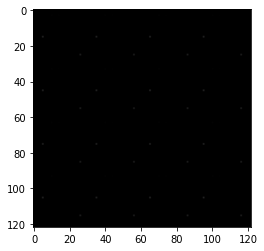

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


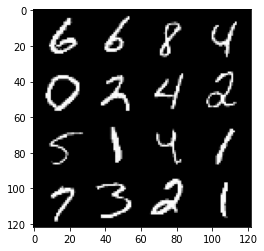

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 30000: Generator loss: 5.866968949794762, discriminator loss: 0.0034760947806062193


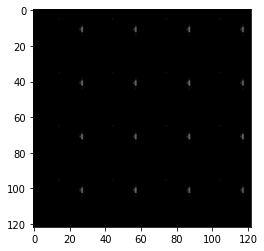

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


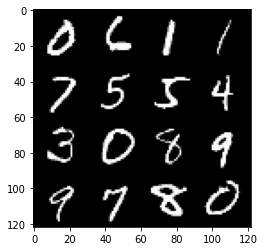

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 31000: Generator loss: 6.1685105710029555, discriminator loss: 0.00253413409291534


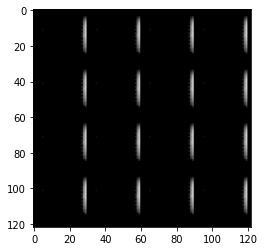

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


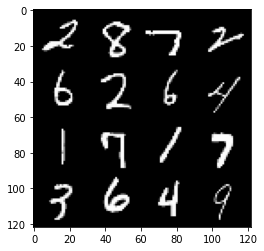

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 32000: Generator loss: 6.5906021804809685, discriminator loss: 0.0017185372715466656


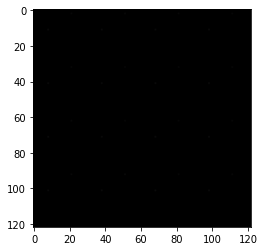

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


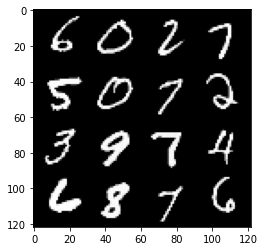

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 33000: Generator loss: 6.869220536708827, discriminator loss: 0.0012270937544235493


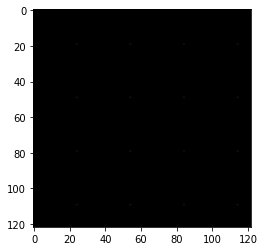

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


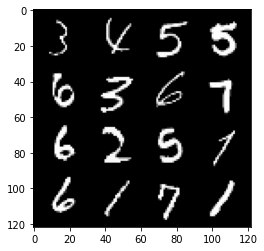

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 34000: Generator loss: 7.352753739833838, discriminator loss: 0.0007524261223297794


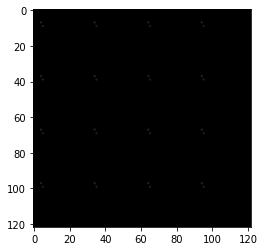

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


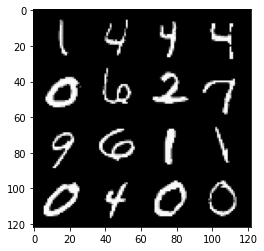

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 35000: Generator loss: 6.253564819872376, discriminator loss: 0.06904985048685923


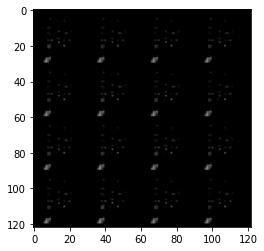

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


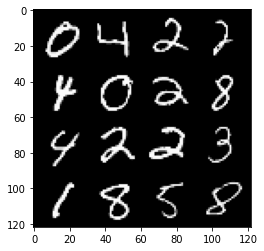

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 36000: Generator loss: 4.804323645591734, discriminator loss: 0.014822016270598403


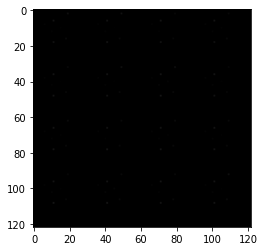

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


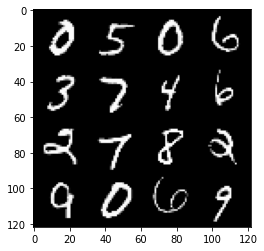

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 37000: Generator loss: 5.896717618942267, discriminator loss: 0.0035342150835203953


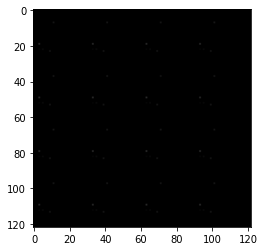

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


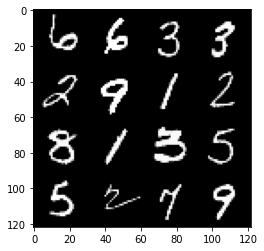

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 38000: Generator loss: 6.247217957496638, discriminator loss: 0.0023451989121967927


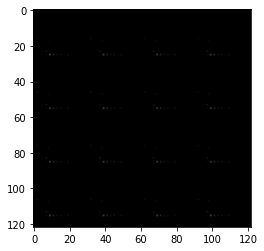

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


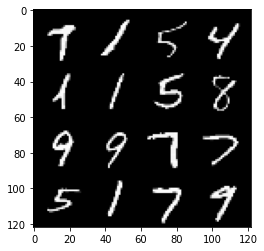

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 39000: Generator loss: 6.781428259849546, discriminator loss: 0.001401050079875859


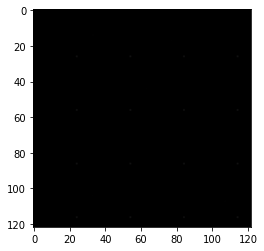

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


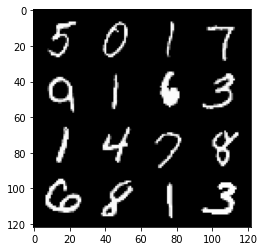

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 40000: Generator loss: 6.985950199604037, discriminator loss: 0.001133649756724481


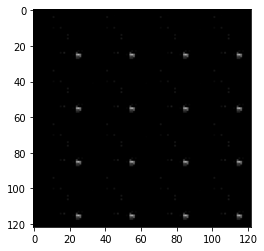

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


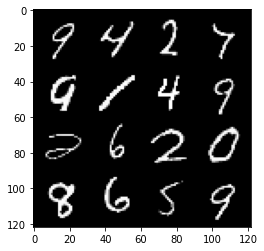

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 41000: Generator loss: 7.30018404150008, discriminator loss: 0.0008382580926991078


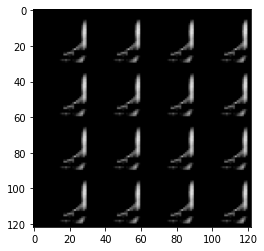

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


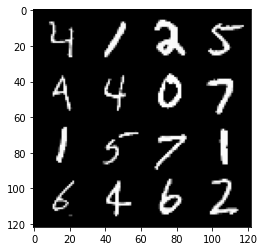

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 42000: Generator loss: 7.635825968742373, discriminator loss: 0.0005918647458893246


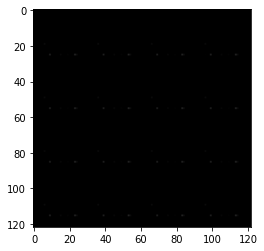

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


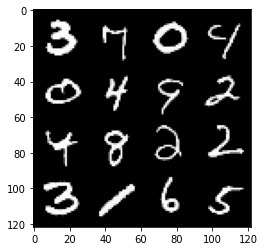

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 43000: Generator loss: 5.148812969326965, discriminator loss: 0.09462046974254207


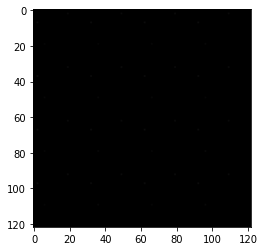

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


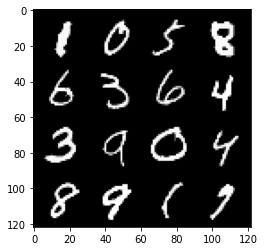

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 44000: Generator loss: 5.359816655159003, discriminator loss: 0.00694989128340967


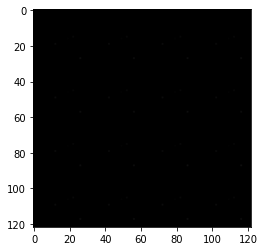

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


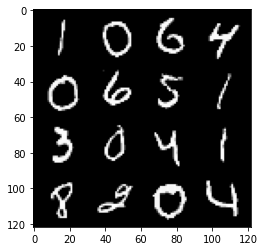

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 45000: Generator loss: 6.05726341676712, discriminator loss: 0.0030350950214778952


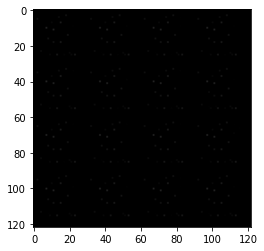

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


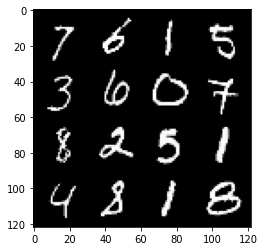

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 46000: Generator loss: 6.686842708110808, discriminator loss: 0.0015507228983915415


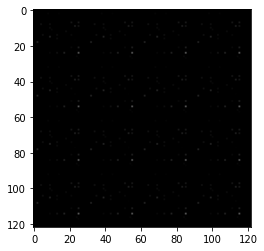

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


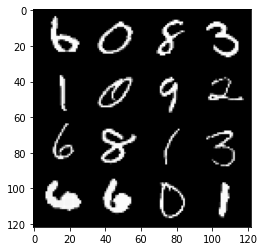

In [9]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0


for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, label in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = gen.get_noise(cur_batch_size, device=device)
        fake = gen(fake_noise)

        # # for fake images
        # detaching generator because we have to update only discriminator weights
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        # for real images
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        # mean discriminator loss
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = gen.get_noise(cur_batch_size, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1